In [28]:
import pandas

orig_files = ["../../original-data/all/heldout_period_data.jsonlist.bz2",
              "../../original-data/all/train_period_data.jsonlist.bz2"]

data_file = "../../data/cmv.annotations.topics.jsonlist"
topics_file = "../../annotations/topics.info"
other_info = "../../annotations/other_info.txt"

# Data stats

In [29]:
import json, bz2

def new_stats():
    return { "trees" : set([]), "replies" : set([]), "ops" : set([]), "participants" : set([])}

def calc_stats(file, stats):
    for line in file:
        cmv = json.loads(line)

        stats["trees"].add(cmv["id"])
        stats["participants"].add(cmv["author"])
        stats["ops"].add(cmv["author"])
        for comment in cmv["comments"]:
            if "author" not in comment:
                continue

            stats["replies"].add(comment["id"])
            stats["participants"].add(comment["author"])

def print_stats(stats):
    return "Trees: %i, Replies: %i, Nodes: %i, OPs: %i, Participants: %i" % (len(stats["trees"]),
                                                                            len(stats["replies"]), 
                                                                            len(stats["trees"]) + len(stats["replies"]),
                                                                            len(stats["ops"]),
                                                                            len(stats["participants"]))

orig_stats = new_stats()
for filename in orig_files:
    calc_stats(bz2.open(filename, 'rb'), orig_stats)

data_stats = new_stats()
calc_stats(open(data_file, "r"), data_stats)

print("Original data:", print_stats(orig_stats))
print("Preprocessed data:", print_stats(data_stats))

Original data: Trees: 20626, Replies: 1258035, Nodes: 1278661, OPs: 13708, Participants: 78652
Preprocessed data: Trees: 20407, Replies: 1254160, Nodes: 1274567, OPs: 13702, Participants: 78589


# Topic stats

In [30]:
from collections import Counter

topics = { line.split(":")[0] : line.split(":")[1].strip() for line in open(topics_file, "r") }

post_topics = [ ]

for line in open(data_file, "r"):
        cmv = json.loads(line)

        if "topic" in cmv:
            post_topics.append(topics[cmv["topic"]])

topics_freq = Counter(post_topics)
topics_freq.most_common(10)

[('-1_the_and_to_of', 6880),
 ('0_music_song_songs_listen', 327),
 ('1_black_white_racism_racist', 233),
 ('2_gun_guns_firearms_weapons', 231),
 ('3_abortion_fetus_prolife_abortions', 230),
 ('4_college_degree_education_students', 220),
 ('5_gender_transgender_trans_sex', 213),
 ('6_meat_animals_eating_eat', 200),
 ('7_climate_warming_global_change', 184),
 ('8_nsa_privacy_information_data', 167)]

# Gender stats

In [31]:
from collections import defaultdict

def calc_gender_stats(file, genderLabel, gender_conv):
    stats = defaultdict(list)
    
    for line in file:
        cmv = json.loads(line)
    
        genderData = cmv[genderLabel]
        gender = gender_conv(genderData, cmv["id"])

        if gender != "UNK":
            stats[gender + "_post"].append(cmv["id"])
            stats[gender + "_topic"].append(cmv["topic"])
            stats[gender + "_auth"].append(cmv["author"])
            stats[gender + "_threads"].append(cmv["id"])

        for comment in cmv["comments"]:
            genderData = comment[genderLabel]
            gender = gender_conv(genderData, comment["id"])

            if gender != "UNK":
                stats[gender + "_reply"].append(comment["id"])
                stats[gender + "_reply_topic"].append(cmv["topic"])
                stats[gender + "_auth"].append(comment["author"])
                stats[gender + "_threads"].append(cmv["id"])

    return stats

conv = lambda gender, cmvId : gender
explicit_stats = calc_gender_stats(open(data_file, "r"), "explicit_gender", conv)
implicit_stats = calc_gender_stats(open(data_file, "r"), "author_gender", conv)

In [32]:
from collections import Counter

def print_topics(c, how_many=10):
    for t, f in dict(c.most_common(how_many)).items():
        if t == "-1":
            continue
        
        print("\_".join(topics[t].split("_")[1:]), " & ", f)

def print_stats(s, genders):
    all_stats = defaultdict(list)
    for gender in genders:
        print("##", gender, ":")
        print("Posts ", gender, len(s[gender + "_post"]))
        print("Replies ", gender, len(s[gender + "_reply"]))
        print("Discussions ", gender, len(set(s[gender + "_threads"])))
        print("Authors ", gender, len(set(s[gender + "_auth"])))

        all_stats["post"] += s[gender + "_post"]
        all_stats["reply"] += s[gender + "_reply"]
        all_stats["discussions"] += s[gender + "_threads"]
        all_stats["authors"] += s[gender + "_auth"]
        print()

    print("All posts:", len(set(all_stats["post"])))
    print("All replies:", len(set(all_stats["reply"])))
    print("All discussions:", len(set(all_stats["discussions"])))
    print("All authors:", len(set(all_stats["authors"])))

<>:8: SyntaxWarning: invalid escape sequence '\_'
<>:8: SyntaxWarning: invalid escape sequence '\_'
/tmp/ipykernel_2184445/655701139.py:8: SyntaxWarning: invalid escape sequence '\_'
  print("\_".join(topics[t].split("_")[1:]), " & ", f)


### Explicit genders

In [33]:
print_stats(explicit_stats, ["M", "F", "N"])

## M :
Posts  M 299
Replies  M 1953
Discussions  M 1357
Authors  M 1640

## F :
Posts  F 89
Replies  F 961
Discussions  F 693
Authors  F 674

## N :
Posts  N 8
Replies  N 321
Discussions  N 175
Authors  N 158

All posts: 396
All replies: 3235
All discussions: 1812
All authors: 2456


### Authors' gender

In [34]:
print_stats(implicit_stats, ["M", "F"])

## M :
Posts  M 2253
Replies  M 227261
Discussions  M 18515
Authors  M 1634

## F :
Posts  F 396
Replies  F 53042
Discussions  F 10119
Authors  F 664

All posts: 2649
All replies: 280303
All discussions: 19016
All authors: 2298


# Plot gender of authors in posts

In [74]:
def get_interesting_topics(stats, genders):
    counters = { gender : Counter(stats[gender + "_topic"]) + Counter(stats[gender + "_reply_topic"]) for gender in genders }
    
    result = { }
    for (top, freq) in sum([tc.most_common(500) for tc in counters.values()], []):
        if top == "-1":
            continue
        
        freq = sum([ tc[top] for tc in counters.values() ])
        result[top] = freq

    result = [ (freq, top) for (top, freq) in result.items() ]
    result.sort(reverse=True)
    result = result[:10]
    return [ top for (_, top) in result ]
     
def reverse_stats(stats):
    result = { top : defaultdict(int) for top in topics }
    for key, tops in stats.items():
        if not key.endswith("topic"):
            continue
        
        for top in tops:
            result[top][key] += 1
            
    return result

tstats = reverse_stats(explicit_stats)
interesting_topics = get_interesting_topics(explicit_stats, ["M", "F", "N"])[:10]

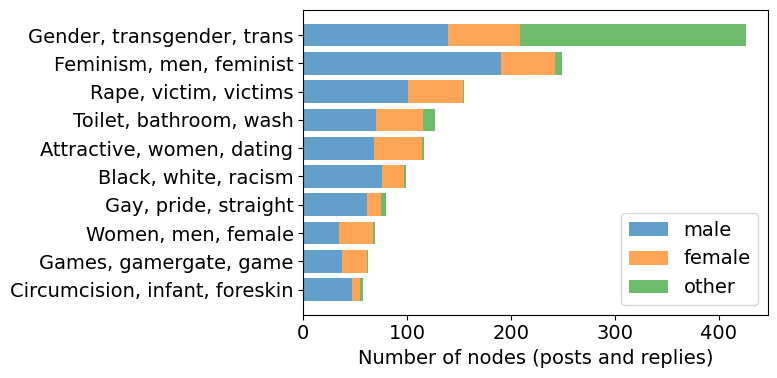

In [75]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams

def setFontSize(fontsize=14):
    rcParams.update({'text.usetex': False}) 
    rcParams.update({'font.size': fontsize})
    rcParams.update({'legend.fontsize': fontsize})
    rcParams.update({'axes.titlesize': fontsize})
    rcParams.update({'axes.labelsize': fontsize})

def setFigureSize():
    fig_size = rcParams["figure.figsize"]
    fig_size[0] = 8
    fig_size[1] = 4
    rcParams["figure.figsize"] = fig_size

def nice_title(title):
    parts = title.split("_")[1:-1]
    result = [ ]
    for p in parts:
        if p == "circumcised":
            p = "infant"

        result.append(p)
    
    return ", ".join(result).capitalize()

def nice_gender(gender):
    if gender == "M":
        return "male"
    elif gender == "F":
        return "female"
    elif gender == "N":
        return "other"
    else:
        return gender

def save_image(out, inbox=None):
    plt.savefig(out, bbox_inches='tight', format="pdf")
    
def plot_topics(interesting_topics, tstats, genders, out_file=None):
    # Sample data for three series
    categories = [ nice_title(topics[top]) for top in interesting_topics[::-1] ]

    setFontSize()
    setFigureSize()

    # Create an array for the y-axis positions
    y = np.arange(len(categories))

    # Create the stacked bar plot
    bars = [ ]
    for gender in genders:
        bars.append([ tstats[top][gender + "_topic"] + tstats[top][gender + "_reply_topic"] + 1 for top in interesting_topics[::-1] ])

    plt.barh(y, bars[0], label=nice_gender(all_genders[0]), alpha=0.7)

    left = bars[0]
    for bar, gender in zip(bars[1:], genders[1:]):
        plt.barh(y, bar, label=nice_gender(gender), alpha=0.7, left=left)
        left = [a + b for a, b in zip(left, bar)]
        
    # Add labels, title, and legend
    #plt.xlabel('Categories')
    plt.xlabel('Number of nodes (posts and replies)')
    cats = plt.yticks(y, categories)
    plt.legend()

    rcParams.update({'figure.autolayout': True})

    if out_file:
        save_image(out_file)

    # Show the plot
    plt.show()

plot_topics(interesting_topics, tstats, ["M", "F", "N"])

# Fine-grained gender stats

In [76]:
all_info = { }
for line in open(other_info, "r"):
    cmvId, info = line.split('\t')
    all_info[cmvId.strip()] = info.strip()

def get_full_gender(gender, cmvId):
    if gender != "N":
        return gender
    
    return all_info[cmvId]

explicit_other = calc_gender_stats(open(data_file, "r"), "explicit_gender", get_full_gender)

In [77]:
print_stats(explicit_other, set(all_info.values()))

## genderqueer :
Posts  genderqueer 1
Replies  genderqueer 30
Discussions  genderqueer 24
Authors  genderqueer 22

## non-binary :
Posts  non-binary 0
Replies  non-binary 19
Discussions  non-binary 16
Authors  non-binary 16

## trans male :
Posts  trans male 1
Replies  trans male 47
Discussions  trans male 32
Authors  trans male 27

## trans :
Posts  trans 2
Replies  trans 73
Discussions  trans 60
Authors  trans 58

## trans female :
Posts  trans female 4
Replies  trans female 152
Discussions  trans female 97
Authors  trans female 76

All posts: 8
All replies: 321
All discussions: 175
All authors: 158


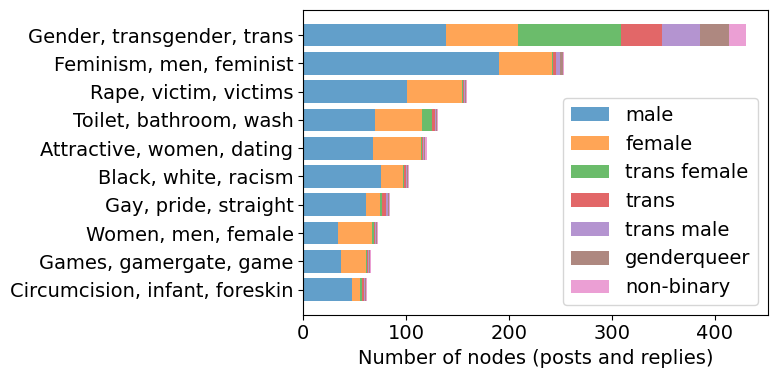

In [78]:
tstats = reverse_stats(explicit_other)
all_genders = ['M', 'F', 'trans female',  'trans', 'trans male', 'genderqueer', 'non-binary' ]
interesting_topics = get_interesting_topics(explicit_other, all_genders)[:10]
plot_topics(interesting_topics, tstats, all_genders,"explicit_topics_all_gender.pdf")